In [1]:
%%capture
!pip install fastai --upgrade
!pip install SemTorch

In [2]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
import torch
# torch.cuda.set_device(1)

In [4]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [5]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
!git clone https://github.com/mavillot/FUNSD-Information-Extraction.git

Cloning into 'FUNSD-Information-Extraction'...
remote: Enumerating objects: 785, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 785 (delta 3), reused 0 (delta 0), pack-reused 775
Receiving objects: 100% (785/785), 50.02 MiB | 22.94 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [7]:
%cd '/content/FUNSD-Information-Extraction/Detection/Segmentation'

/content/FUNSD-Information-Extraction/Detection/Segmentation


In [8]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [9]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels"))



Aux function for splitting between training and testing


In [10]:
def ParentSplitter(x):
    return Path(x).parent.name=='test'

Loading the codes of the different classes. All the datasets have the same codes.

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Early Stopping parameters

In [12]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=4

In [13]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [23]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Rotate(p=0.40,limit=10),GridDistortion(),ShiftScaleRotate(), ElasticTransform(),
                        OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [24]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [25]:
path_manual_img = path_images
path_manual_lbl = path_labels

dataset/Images/test/87332450.png


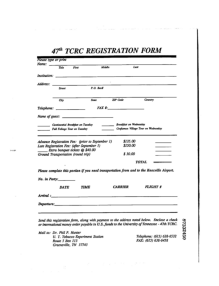

In [26]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [27]:
print(get_y_fn(img_f))

dataset/Labels/test/87332450.png


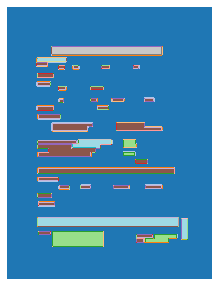

In [28]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [29]:
np.unique(np.array(mask))

array([0, 1, 2, 3, 4], dtype=uint8)

In [30]:
size = (1000,754)
bs = 1

In [31]:
codes

array(['Background', 'answer', 'question', 'header', 'other'],
      dtype='<U10')

In [32]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize(size), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
#dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [ ]:
#x,mask=dls.one_batch()

# ResNet34

In [33]:
learn = unet_learner(dls, resnet34, metrics=[DiceMulti], self_attention=True, 
                     act_cls=Mish, opt_func=ranger).to_fp16()

# get_segmentation_learner(dls=dls, number_classes=3, segmentation_type="Semantic Segmentation",
#                                  architecture_name="unet", backbone_name="resnet34", 
#                                  metrics=[background,cytoplasm,nucleus,msa],wd=1e-2,
#                                  pretrained=True,normalize=True).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Recorder

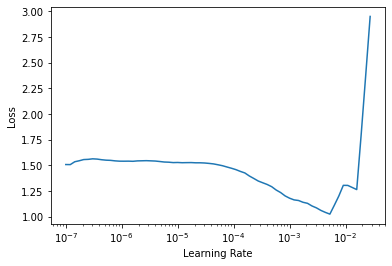

In [ ]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice_multi,time
0,0.420551,0.422588,0.348964,00:57
1,0.401099,0.483079,0.323697,00:58
2,0.353966,0.401171,0.375663,00:58
3,0.357790,0.417938,0.364149,00:57
4,0.346500,0.405763,0.316726,00:57
5,0.351003,0.412800,0.390210,00:57
6,0.328772,0.396491,0.386484,00:57
7,0.335644,0.414036,0.373866,00:56
8,nan,0.961517,0.315002,00:56
9,nan,nan,0.268428,00:56


Better model found at epoch 0 with valid_loss value: 0.4225884974002838.


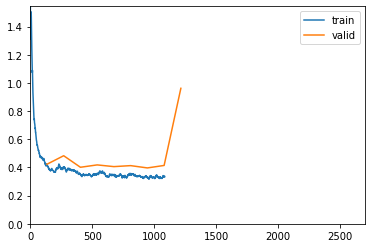

Better model found at epoch 2 with valid_loss value: 0.4011708199977875.
Better model found at epoch 6 with valid_loss value: 0.39649149775505066.
No improvement since epoch 6: early stopping


In [ ]:
fname="unet-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
lr = 3e-3
learn.fit_flat_cos(20, slice(lr),cbs=callbacksFitBeforeUnfreeze)

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Recorder

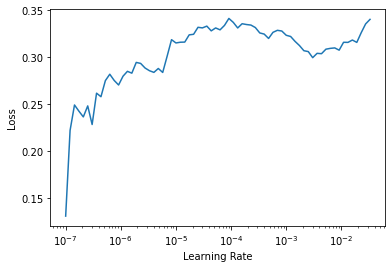

In [ ]:
learn.load("unet-before-unfreeze")
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice_multi,time
0,0.308518,0.389098,0.399612,00:59
1,0.302897,0.400227,0.407950,00:59
2,0.291396,0.378056,0.439519,00:59
3,0.299848,0.396301,0.442863,00:59
4,0.283055,0.374445,0.473456,00:59
5,0.266519,0.375546,0.472264,00:59
6,0.257617,0.383246,0.473998,00:59
7,0.256693,0.380002,0.511451,01:00
8,0.239175,0.372405,0.524698,00:59
9,0.230212,0.395661,0.493386,00:59


Better model found at epoch 0 with valid_loss value: 0.3890978991985321.


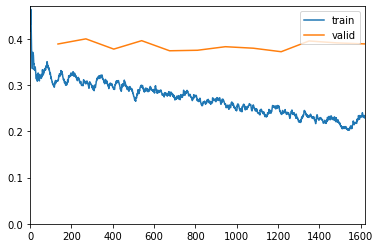

Better model found at epoch 2 with valid_loss value: 0.3780563473701477.
Better model found at epoch 4 with valid_loss value: 0.37444543838500977.
Better model found at epoch 8 with valid_loss value: 0.37240490317344666.


In [ ]:
fname="unet-after-unfreeze"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(12, slice(lr/400, lr/4),cbs=callbacksFitAfterUnfreeze)

In [ ]:
learn.save('unet')

Path('models/model_1.pth')

In [14]:
import torchvision.transforms as transforms
import PIL
img = PILImage.create("dataset/Images/test/82092117.png")
transformer=transforms.Compose([transforms.Resize((1000,754)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()


In [ ]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux,(img))
traced_cell.save("unet.pth")

In [ ]:
dbtest = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize(size), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
testDLS = dbtest.dataloaders(path_images,bs=bs)

learn.dls = testDLS

learn.validate()

(#2) [0.31741172075271606,0.5485682045200357]

## Predicciones

In [16]:
import PIL
import cv2
img = cv2.imread('dataset/Images/test/82092117.png')

In [34]:
model = learn.model

In [17]:
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [18]:
img = cv2.imread('dataset/Images/test/82092117.png')
img = Image.fromarray(img)
image = transforms.Resize((1000,754))(img)
tensor = transform_image(image=image)

In [35]:
model.to(device)
with torch.no_grad():
    outputs = model(tensor)

outputs = torch.argmax(outputs,1)

In [36]:
mask = np.array(outputs.cpu())
mask=np.reshape(mask,(1000,754))

In [39]:
def mostrarImagen(image,h=20,w=15):
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    plt.figure(figsize=(h,w))
    plt.imshow(img2)
    plt.show()
  else:
    img2 = image
    plt.figure(figsize=(h,w))
    plt.imshow(img2,cmap='gray')
    plt.show()

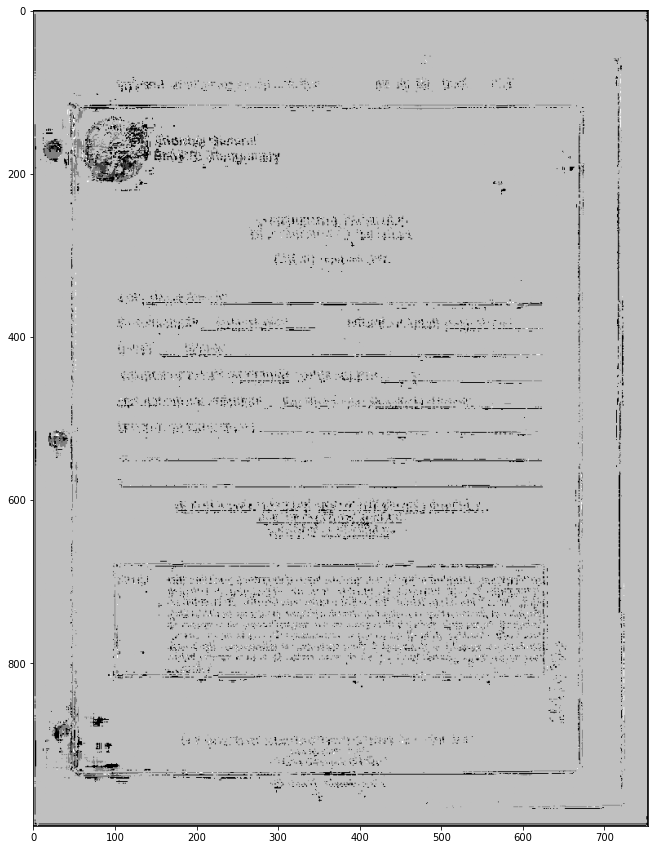

In [40]:
mostrarImagen(mask)

### Transformation to RGB mask

In [ ]:
np.unique(mask)

array([0, 1, 2, 3, 4])

In [41]:
mask=np.array(mask,dtype='uint8')
maskRGB = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)

In [42]:
matrix=maskRGB==1
matrix[:,:,1:3]=False
maskRGB[matrix]=255


matrix=maskRGB==2
matrix[:,:,[0,2]]=False
maskRGB[matrix]=255


matrix=maskRGB==3
matrix[:,:,:2]=False
maskRGB[matrix]=255

maskRGB[maskRGB==4]=178

maskRGB[maskRGB==0]=255

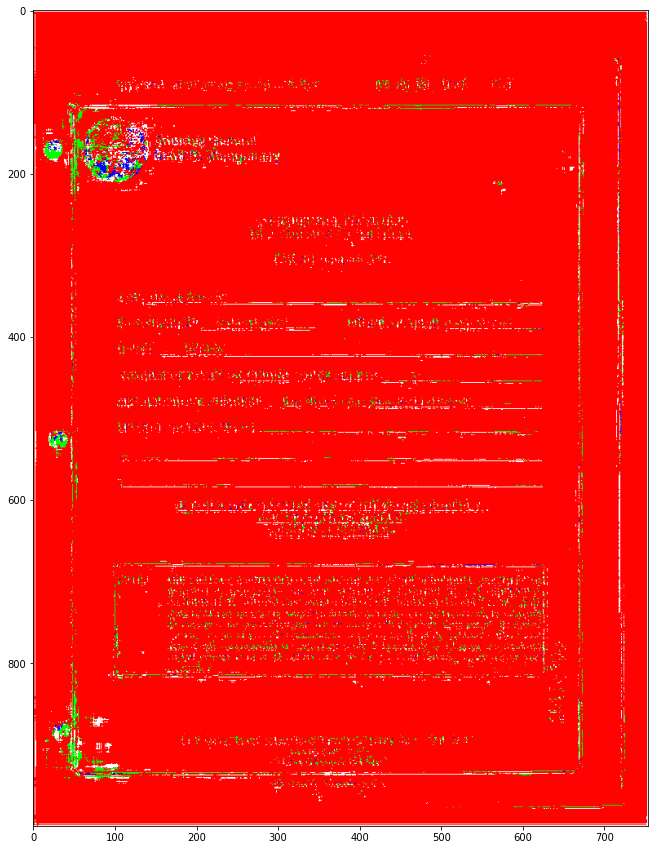

In [43]:
mostrarImagen(maskRGB)

In [44]:
img = Image.fromarray(maskRGB.astype('uint8'))

In [45]:
img.save('test.png')

In [ ]:
get_image_files('dataset/Images/test')

(#50) [Path('dataset/Images/test/93106788.png'),Path('dataset/Images/test/87093315_87093318.png'),Path('dataset/Images/test/86244113.png'),Path('dataset/Images/test/87137840.png'),Path('dataset/Images/test/82250337_0338.png'),Path('dataset/Images/test/82092117.png'),Path('dataset/Images/test/87594142_87594144.png'),Path('dataset/Images/test/87147607.png'),Path('dataset/Images/test/82252956_2958.png'),Path('dataset/Images/test/83635935.png')...]

In [ ]:
for imPath in get_image_files('dataset/Images/test'):
    img = cv2.imread(str(imPath))
    img = Image.fromarray(img)
    image = transforms.Resize((1000,754))(img)
    tensor = transform_image(image=image)
    model.to(device)
    with torch.no_grad():
        outputs = model(tensor)

    outputs = torch.argmax(outputs,1)
    mask = np.array(outputs.cpu())
    mask=np.reshape(mask,(1000,754))
    mask=np.array(mask,dtype='uint8')
    maskRGB = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)

    matrix=maskRGB==1
    matrix[:,:,1:3]=False
    maskRGB[matrix]=255


    matrix=maskRGB==2
    matrix[:,:,[0,2]]=False
    maskRGB[matrix]=255


    matrix=maskRGB==3
    matrix[:,:,:2]=False
    maskRGB[matrix]=255

    maskRGB[maskRGB==4]=178

    maskRGB[maskRGB==0]=255

    img = Image.fromarray(maskRGB.astype('uint8'))
    img.save('hrnetPreds/'+imPath.name)

In [ ]:
for imPath in get_image_files('dataset/Images/test'):
    img = cv2.imread(str(imPath))
    img = Image.fromarray(img)
    image = transforms.Resize((1000,754))(img)
    tensor = transform_image(image=image)
    model.to(device)
    with torch.no_grad():
        outputs = model(tensor)

    outputs = torch.argmax(outputs,1)
    mask = np.array(outputs.cpu())
    mask=np.reshape(mask,(1000,754))
    img = Image.fromarray(mask.astype('uint8'))
    img.save('deeplabPreds/'+imPath.name)

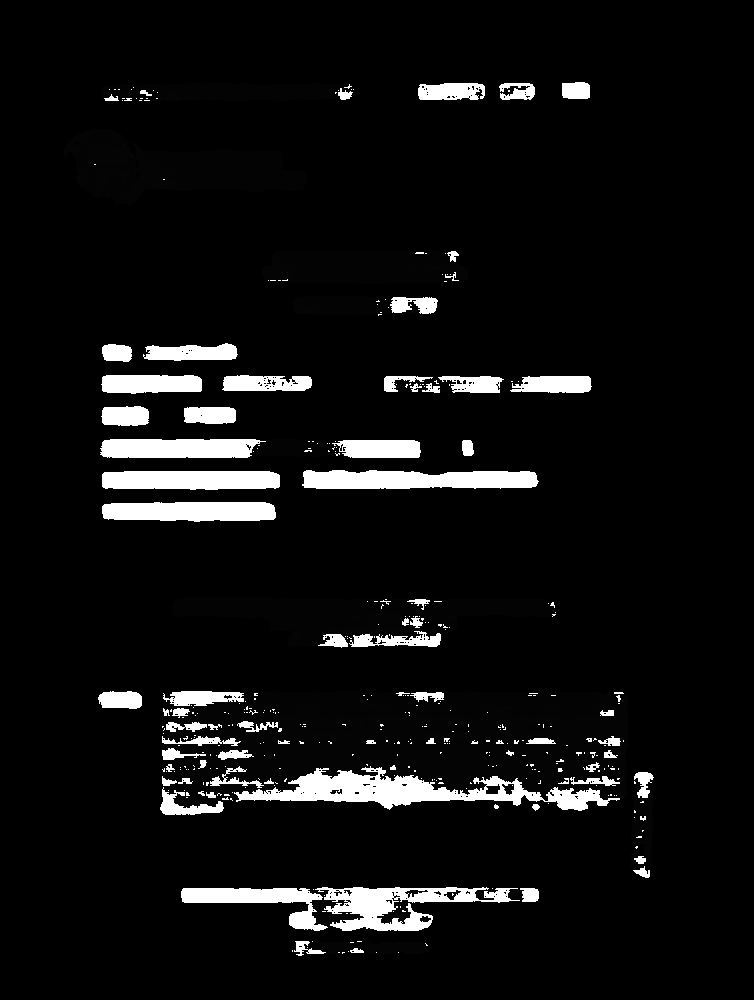

In [ ]:
mask=np.reshape(mask,(1000,754))
mask[mask==2]=255
Image.fromarray(mask.astype('uint8'))

In [ ]:
for imPath in get_image_files('dataset/Images/test'):
    img = cv2.imread(str(imPath))
    img = Image.fromarray(img)
    image = transforms.Resize((1000,754))(img)
    tensor = transform_image(image=image)
    model.to(device)
    with torch.no_grad():
        outputs = model(tensor)

    outputs = torch.argmax(outputs,1)
    mask = np.array(outputs.cpu())
    mask=np.reshape(mask,(1000,754))
    img = Image.fromarray(mask.astype('uint8'))
    img.save('unetPreds/'+imPath.name)